# Exec summary: Retention, churn, and growth opportunities

**Dataset**: Open-source e-commerce behavior dataset from Kaggle adapted for product analytics simulation

**Objective:** Surface clear product actions and testable hypotheses from behavioral signals to enable strategy, product + lifecycle marketing

- **Discounts aren't universally effective** → aligns with high satisfaction among gold users but correlates with lower satisfaction in bronze and silver tiers, suggesting promo fatigue or misalignment
- **Satisfied users spend 2x more than others** → satisfaction is a high-leverage flag for retention-led growth strategies and CLTV modeling
- **Power users are active, recent, and high-spend** → potential leading indicator of product-market fit → track what unlocks their behavior to scale activation
- **Silver users show lapsed loyalty patterns** → decent spend but high churn risk → reactivation messaging, winback flows, or UX audits
- **Bronze users likely need better onboarding or value communication** → they churn early, even with discounts → focus on product education over promo incentives
- **Segment by city and tier** e.g., Silver/Miami and Bronze/Chicago to tailor retention messaging, activation nudges, or A/B tests

In [25]:
# Import
from google.colab import files
import os

In [26]:
# Upload Kaggle api key
uploaded = files.upload()

# Rename file
os.rename("kaggle (4).json", "kaggle.json")


Saving kaggle (4).json to kaggle (4).json


In [27]:
# Set up the key for cli
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [28]:
# Download dataset
!kaggle datasets download -d uom190346a/e-commerce-customer-behavior-dataset

# Unzip the downloaded file
!unzip e-commerce-customer-behavior-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/uom190346a/e-commerce-customer-behavior-dataset
License(s): CC0-1.0
e-commerce-customer-behavior-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  e-commerce-customer-behavior-dataset.zip
replace E-commerce Customer Behavior - Sheet1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: E-commerce Customer Behavior - Sheet1.csv  


In [29]:
# Load into pandas

import pandas as pd

df = pd.read_csv("E-commerce Customer Behavior - Sheet1.csv")
df.sample()

# Looking for behavior signals, user segmentation, and actionable insights that drive product velocity
# Translate customer behavior into decision-making power
# Where's the friction? What drives retention, sastisfaction, and churn?

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
159,260,Male,28,San Francisco,Gold,1500.1,21,4.9,False,10,Satisfied


In [30]:
# 2. Normalize / setup the data for eda

In [31]:
# Standardize col names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [32]:
# Format key cols
df['days_since_last_purchase'] = pd.to_numeric(df['days_since_last_purchase'], errors='coerce')
df['total_spend'] = pd.to_numeric(df['total_spend'], errors='coerce')

In [33]:
# Add fields to map lifecycle
df['discount_applied'] = df['discount_applied'].astype(int)  # convert True/False to 1/0

# Will later use this to segment by:
# Recency = days since last purchase
# Frequency = items purchased
# Monetary = total spend
# Satisfaction proxy = satisfaction level
# Discount behavior = discount applied (binary)

In [34]:
# Evauate missing/incompletes
df.isnull().sum()

,0
customer_id,0
gender,0
age,0
city,0
membership_type,0
total_spend,0
items_purchased,0
average_rating,0
discount_applied,0
days_since_last_purchase,0


In [35]:
# Might segment or correlate against satisfaction level later e.g. churn risk modeling so fill missing vals with "unknown" for now
df['satisfaction_level'] = df['satisfaction_level'].fillna('Unknown')

In [36]:
df.head()

,customer_id,gender,age,city,membership_type,total_spend,items_purchased,average_rating,discount_applied,days_since_last_purchase,satisfaction_level
0,101,Female,29,New York,Gold,1120.20,14,4.6,1,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,0,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,1,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,0,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,1,55,Unsatisfied


In [37]:
# 3. EDA / make behavioral summaries

In [38]:
# How does user engagement vary by membership type?

# Avg items and spend by membership type
df.groupby('membership_type')[['items_purchased', 'total_spend']].mean()

# Gold users spend ~3x more than Bronze → double down on Gold retention and loyalty
# Silver shows mid engagement but spends significantly more than Bronze → strong potential for converting to Gold → test nudges to increase engagement
# Bronze may represent new, at-risk, or underserved user segments → segment further and tailor onboarding or reactivation flows
# Clear behavioral signal of loyalty and value

# Testing recs:
# A/B test onboarding emails that fast-track Bronze users to their first reward or goal
# Run a satisfaction survey targeting Silver to discover what's holding them back
# Personalize nudges for Silver users who are just below Gold thresholds

,items_purchased,total_spend
membership_type,,
Bronze,8.491379,473.388793
Gold,17.615385,1311.144444
Silver,11.658120,748.432479


In [39]:
# Are discount users more satisfied?

# Satisfaction vs discount use
df.groupby('discount_applied')['satisfaction_level'].value_counts(normalize=True)

# 66% of discounted users are unsatisfied → discounting is not improving satisfaction
# Discounts are not signaling value or improving UX for this group
# Promotions may be reducing perceived value or failing to deliver a strong post-purchase experience

# Flag: discounts may attract users who seek a high discount and churn quickly → misalignment/mismatch
# Evaluate: low loyalty bargain hunters, users with higher expectations, poor onboarding after promo
# Look into where and how the discounts are surfaced

# Next step: segmented discount analysis
# Are Bronze users make up the majority of unsatisfied users?
# Do certain demographics skew more negative?
# Do high spend or repeat discount users tend to rate lower?

discount_applied  satisfaction_level
0                 Neutral               0.611429
                  Satisfied             0.377143
                  Unknown               0.011429
1                 Unsatisfied           0.662857
                  Satisfied             0.337143
Name: proportion, dtype: float64

In [40]:
# Segmented discounting analysis: membership

# Satisfaction by membership type (discounted users only)
discounted = df[df['discount_applied'] == 1]
membership_satisfaction = discounted.groupby(['membership_type', 'satisfaction_level']).size().unstack().fillna(0)
membership_satisfaction = membership_satisfaction.div(membership_satisfaction.sum(axis=1), axis=0)
membership_satisfaction

# Suggests price incentives are not solving the underlying friction for lower-tier users
# Implies discounts might be mismatched for lower-tier users
# If UX or value doesn't meet expectations then price cuts alone won't increase loyalty



satisfaction_level,Satisfied,Unsatisfied
membership_type,,
Bronze,0.0,1.0
Gold,1.0,0.0
Silver,0.0,1.0


In [41]:
# Segmented discounting analysis: city

# Satisfaction by top 5 cities (discounted users only)
top_cities = discounted['city'].value_counts().head(5).index
city_satisfaction = discounted[discounted['city'].isin(top_cities)]
city_satisfaction = city_satisfaction.groupby(['city', 'satisfaction_level']).size().unstack().fillna(0)
city_satisfaction = city_satisfaction.div(city_satisfaction.sum(axis=1), axis=0)
city_satisfaction

# Implies geographic context impacts perceived value
# Consider regional behavior norms, local competition, and onboarding friction

satisfaction_level,Satisfied,Unsatisfied
city,,
Chicago,0.0,1.0
Miami,0.0,1.0
New York,1.0,0.0


In [42]:
# Segmented discounting analysis actionable insights per stakeholder

# 1. Marketing - refine targeting criteria for price based promotions, prioritizing Gold & NY users
# 2. Product / CX - investigate Bronze & Silver misalignment. Confusing features? Steep onboarding?
# 3. Growth - A/B test value-based incentives for lower tier users e.g. onboarding help, access to bonus features


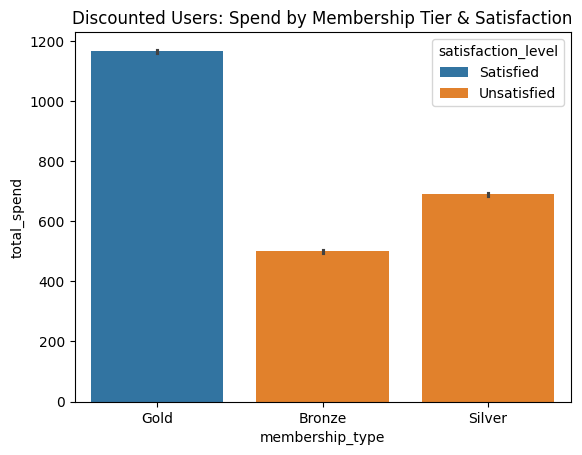

In [43]:
# Segmented discounting analysis: spend

# Filter for discount users
discounted_users = df[df['discount_applied'] == 1]

# Group by membership type
# Are higher tier users spend more or purchase more often with discounts? Are lower tier users less responsive?
discounted_users.groupby('membership_type')[['items_purchased', 'total_spend']].mean()

# Group by city
# Do high satisfaction cities purchase more post-discount?
discounted_users.groupby('city')[['items_purchased', 'total_spend']].mean()

# Avg. spend and purchase frequency by membership type + satisfaction
# Confirm: Satisfied gold users have high ROI? Unsatisfied bronze users have low ROI?
discounted_users.groupby(['membership_type', 'satisfaction_level'])[['items_purchased', 'total_spend']].mean()

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=discounted_users,
    x='membership_type',
    y='total_spend',
    hue='satisfaction_level'
)
plt.title("Discounted Users: Spend by Membership Tier & Satisfaction")
plt.show()

# Gold users spend more and feel good about it
# Silver and bronze users spend less and are still unsatisfied about it → non ICP? Mismatched expectations?

# Gold users convert into value while others may need a different approach
# Blanket discounting may dilute ROI by overserving low value segments
# Test value/experience based perks for lower tiers instead of price based incentives

# Marketing -
# Double down on price based discounting for high ROI gold lookalike users
# Send bronze users value messaging instead of offering price cuts
# Geo target adjustments in Miami and Chicago

# Product / UX -
# Examine friction and dissatisfaction drivers in bronze and silver flows
# Is discounting masking a UX or value gap? Examine unsatisfied users that churn soon after redeeming offers

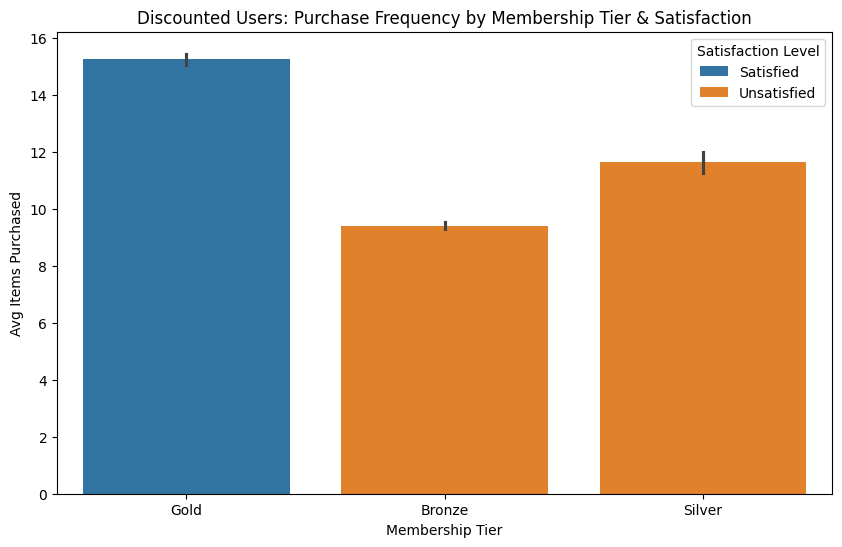

In [44]:
# Segmented discounting analysis: purchase frequency

import seaborn as sns
import matplotlib.pyplot as plt

# Filter for discounted users
discounted = df[df['discount_applied'] == 1]

# Avg. items purchased (proxy for purchase frequency)
plt.figure(figsize=(10,6))
sns.barplot(
    data=discounted,
    x='membership_type',
    y='items_purchased',
    hue='satisfaction_level'
)
plt.title("Discounted Users: Purchase Frequency by Membership Tier & Satisfaction")
plt.ylabel("Avg Items Purchased")
plt.xlabel("Membership Tier")
plt.legend(title="Satisfaction Level")
plt.show()

# Quantifies what we know:
# Gold is satisfied and purchases the most by far → retention led growth loops
# Bronze and silver users are unsatisfied and purchase less → test value not price incentives

In [45]:
# Segmented discounting analysis insights

# Tier-gate discounts:
# For gold users, keep discounting as-is or expand
# For bronze/silver users, test alternative UX, CX, and product offers instead of more discounts
# Track satisfaction lift, not just purchase, to guide rollout

# Post-activation targeting:
# Delay discounts until after activation e.g. after 2+ purchases or other key milestone
# Use early engagement signals as discount triggers e.g. frequent browsing, adding to cart
# Does post-activation discount timing improve satisfaction for bronze/silver users?
# Is there a tipping point where (1) activation + (2) discount = higher retention?

# Value messaging:
# Test value focused copy to reposition the offering rather than % off
# Consider bundling or VIP formats to emphasize experience, not price
# For bronze/silver, measure:
## Satisfaction delta for value messaging vs standard promo
## Short term spend vs long term retention for these users who got the value messaging

In [46]:
# Who are our power users?

# Power users: top 10% spenders
spend_cutoff = df['total_spend'].quantile(0.90)
power_users = df[df['total_spend'] >= spend_cutoff]
power_users[['total_spend', 'days_since_last_purchase']].describe()

# Avg. spend = ~$1.5k
# Recent activity = last purchase ~11 days ago

# Power users spend more and consistently
# Small standard deviation shows this segment is cohesive (not defined by outliers)
# All recently active <15 days
# Opportunity: reinforce retention or upsell

,total_spend,days_since_last_purchase
count,43.000000,43.000000
mean,1480.504651,11.255814
std,15.485692,1.663230
min,1460.500000,9.000000
25%,1470.500000,10.000000
50%,1480.100000,11.000000
75%,1490.100000,13.000000
max,1520.100000,15.000000


In [49]:
# Power users analysis: segment by satisfaction, membership, city, purchases

# Example breakdown
power_users.groupby(['membership_type', 'satisfaction_level'])[['items_purchased']].mean()

,,items_purchased
membership_type,satisfaction_level,
Gold,Satisfied,20.534884


In [50]:
# Power users analysis: power vs general users

# Simple comparison
df['is_power_user'] = df['total_spend'] >= spend_cutoff
df.groupby('is_power_user')[['items_purchased', 'days_since_last_purchase']].mean()

,items_purchased,days_since_last_purchase
is_power_user,,
False,11.488599,28.736156
True,20.534884,11.255814


In [51]:
# Power users analysis: predictors

# Add flag for power users
df['is_power_user'] = df['total_spend'] >= spend_cutoff

# Compare average item count and recency for power vs others
df.groupby('is_power_user')[['items_purchased', 'days_since_last_purchase']].mean()

,items_purchased,days_since_last_purchase
is_power_user,,
False,11.488599,28.736156
True,20.534884,11.255814


In [52]:
# Power users analysis: received discounts

# How many received discounts?
df.groupby('is_power_user')['discount_applied'].mean()


,discount_applied
is_power_user,
False,0.570033
True,0.000000


In [47]:
# Where might churn happen?

# At-risk users: no purchase in 20+ days
at_risk = df[df['days_since_last_purchase'] > 20]
at_risk[['total_spend', 'satisfaction_level']].value_counts()

# Many mid tier users are spending enough to be engaged but not enough to feel the value → churn risk
# Neutral users with low spend may be passively engaged → need nudge or delight otherwise churn risk
# Evaluate discounting strategy for low satisfaction users → if investing price incentives here, it's not working

,,count
total_spend,satisfaction_level,
710.40,Unsatisfied,15
505.75,Unsatisfied,12
1140.60,Satisfied,11
430.80,Neutral,11
660.30,Unsatisfied,8
485.25,Unsatisfied,7
440.90,Neutral,7
480.25,Unsatisfied,7
680.30,Unsatisfied,7


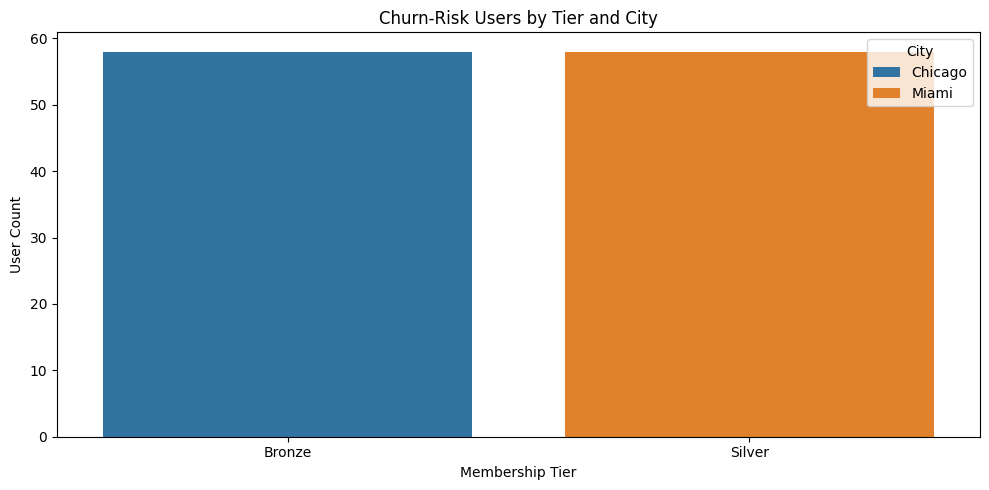

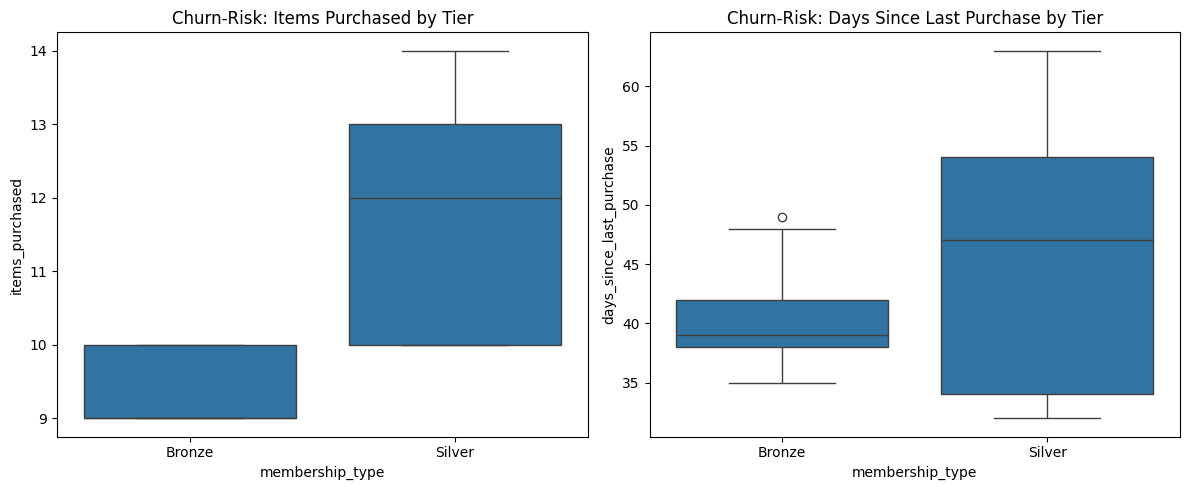

In [54]:
# Churn risk analysis: Segment

import pandas as pd

# Step 1: Define churn risk segment
# Moderate spend range and unsatisfied
churn_risk = df[
    (df['total_spend'] >= 450) &
    (df['total_spend'] <= 750) &
    (df['satisfaction_level'] == 'Unsatisfied')
]

# Step 2: Summarize by membership tier and city
tier_city_summary = churn_risk.groupby(['membership_type', 'city']).size().reset_index(name='count')

# Step 3: Describe behavioral patterns
behavior_summary = churn_risk[['items_purchased', 'days_since_last_purchase']].describe()


import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Count of churn-risk users by membership type and city
plt.figure(figsize=(10, 5))
sns.barplot(data=tier_city_summary, x='membership_type', y='count', hue='city')
plt.title('Churn-Risk Users by Tier and City')
plt.ylabel('User Count')
plt.xlabel('Membership Tier')
plt.legend(title='City')
plt.tight_layout()
plt.show()

# Plot 2: Behavior distribution (boxplot)
plt.figure(figsize=(12, 5))

# Items Purchased
plt.subplot(1, 2, 1)
sns.boxplot(data=churn_risk, x='membership_type', y='items_purchased')
plt.title('Churn-Risk: Items Purchased by Tier')

# Days Since Last Purchase
plt.subplot(1, 2, 2)
sns.boxplot(data=churn_risk, x='membership_type', y='days_since_last_purchase')
plt.title('Churn-Risk: Days Since Last Purchase by Tier')

plt.tight_layout()
plt.show()


# Not all churn risk is equal
# Opportunity: Silver users buy more but wait longer → evaluate lapsed loyal vs poor fit users → reengage lapsed loyal
# Bronze users buy and use less → evaluate for onboarding friction or value misalignment → consider product education retention loops

# Bronze churn risk users are concentrated in Chicago
# Silver churn risk users are concentrated in Miami
# Suggests city-tier interactions influence retention → test local preferences and feature nudges

In [48]:
# Does satisfaction align with spend?

# Spend by satisfaction
df.groupby('satisfaction_level')['total_spend'].mean()

# Satisfied users → 2x+ spend delta
# Neutral → may be passive, may drift without support
# Unknowns rep. the 2 missing values we cleaned

# Design experiments to lift satisfaction through onboading nudgesm product value messaging, or better UX
# Analyze feature usage, support itneractions, or speed to value among satisfied users
# Audit survey feedback

,total_spend
satisfaction_level,
Neutral,616.414019
Satisfied,1280.319200
Unknown,425.800000
Unsatisfied,595.136207


In [48]:
# Summary:
# Satisfied users spend 2x more than others
# Discounts do not correlate with higher satisfaction among bronze/silver users
# Churn risk clusters around moderate spend + long gaps since last purchase
# Power users are very recent, very active

# Test recs:
# 1. Tier-gated discounts post-activation
# 2. Nudges for Neutral users to reinforce value
# 3. Re-engagement for churn-risk clusters

# Next steps:
# Analyze features by satisfaction level
# Build predictive churn flags from behavioral data
# Self-servedashboard for PMs